# PCA

A análise de componentes será feita utilizando o método jackknife para encontrar o número ótimo de componentes do PCA. Depois é aplicado o método Kennard-Stone para dividir as amostras em 70-30. Plota gráficos de outliers (T² e Q).

# Imports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Método Jackknife

In [2]:
def jackknife_pca(X, threshold=0.01):
    n_samples = X.shape[0]
    variances = []
    
    for i in range(n_samples):
        X_jack = np.delete(X, i, axis=0)
        pca = PCA().fit(X_jack)
        variances.append(pca.explained_variance_ratio_)
    
    variances = np.mean(variances, axis=0)
    
    for i in range(len(variances) - 1):
        if variances[i] - variances[i + 1] < threshold:
            return i + 1
    return len(variances)

# Método Kennard-Stone

In [3]:
def kennard_stone(X, train_size=0.7):
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)

    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")

    # Calcula as distâncias entre cada par de pontos
    distances = cdist(X, X, metric='euclidean')

    # Primeiro ponto: aquele mais distante da média
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]

    for _ in range(1, n_train):
        # Calcula a menor distância de cada ponto ao conjunto já selecionado
        min_distances = np.min(distances[selected], axis=0)
        min_distances[selected] = -np.inf  # Evita escolher um ponto já selecionado
        next_sample = np.argmax(min_distances)  # Escolhe o mais distante

        selected.append(next_sample)

    return np.array(selected)


# Plot and save

In [4]:
def plot_data(outliers, T2, Q, T2_limit, Q_limit, cumulative_variance, optimal_components):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_variance, label='Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal Components: {optimal_components}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(T2, Q, c=outliers, cmap='coolwarm', edgecolor='k')
    plt.axhline(np.percentile(Q, 100 * (1 - 0.027)), color='r', linestyle='--', label=f'Q Limit: {np.percentile(Q, 100 * (1 - 0.02)):.2f}')
    plt.axvline(T2_limit, color='g', linestyle='--', label=f'T2 Limit: {T2_limit:.2f}')
    plt.xlabel("Hotelling's T²")
    plt.ylabel('F-residual')
    plt.title('Outlier Detection')
    plt.legend(title='Limits')

    plt.tight_layout()
    plt.show()

def save_datasets(calibration_set, validation_set, dataset_path, dataset_dir):
    base_name = os.path.splitext(os.path.basename(dataset_path))[0]  # Pega apenas o nome do arquivo sem extensão
    calibration_path = os.path.join(dataset_dir, f"{base_name}_calibracao.xlsx")
    validation_path = os.path.join(dataset_dir, f"{base_name}_validacao.xlsx")

    calibration_set.to_excel(calibration_path, index=False)
    validation_set.to_excel(validation_path, index=False)


# Main

Shape dos dados normalizados: (250, 2151)
Número de amostras na calibração: 175


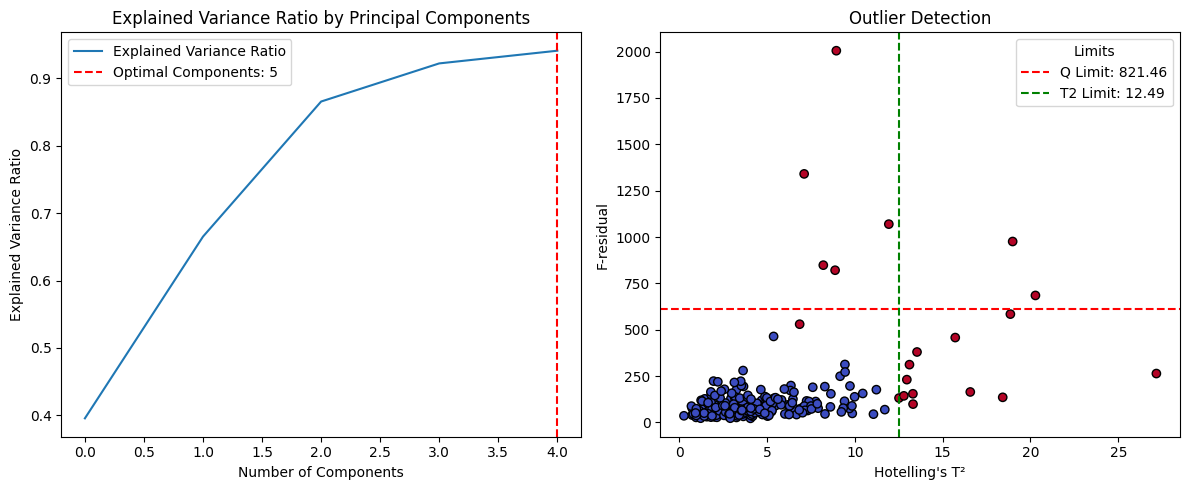

Arquivo msc_processed.xlsx processado com 5 componentes principais do PCA.
Shape dos dados normalizados: (250, 2151)
Número de amostras na calibração: 175


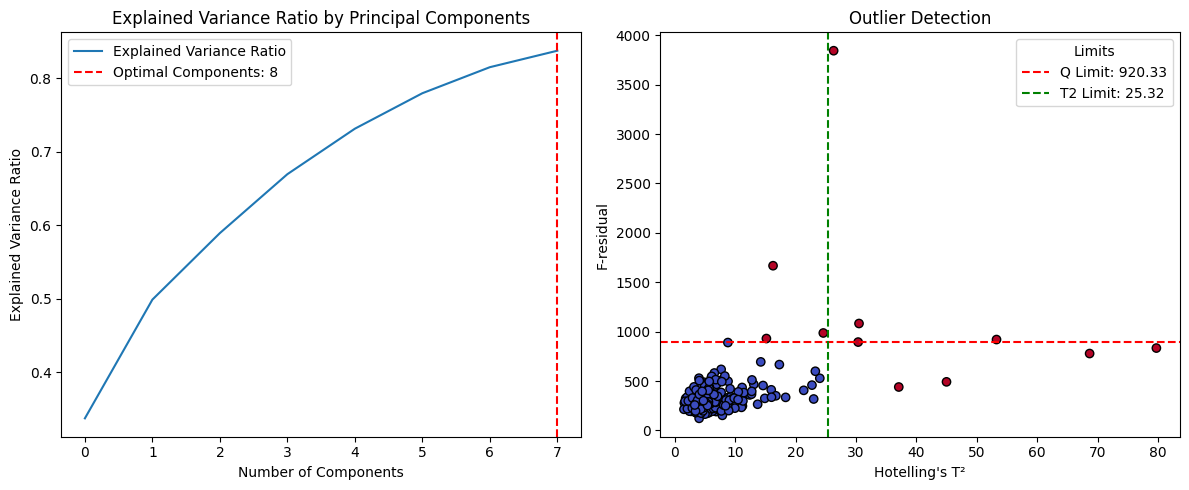

Arquivo sg_processed.xlsx processado com 8 componentes principais do PCA.
Shape dos dados normalizados: (250, 2151)
Número de amostras na calibração: 175


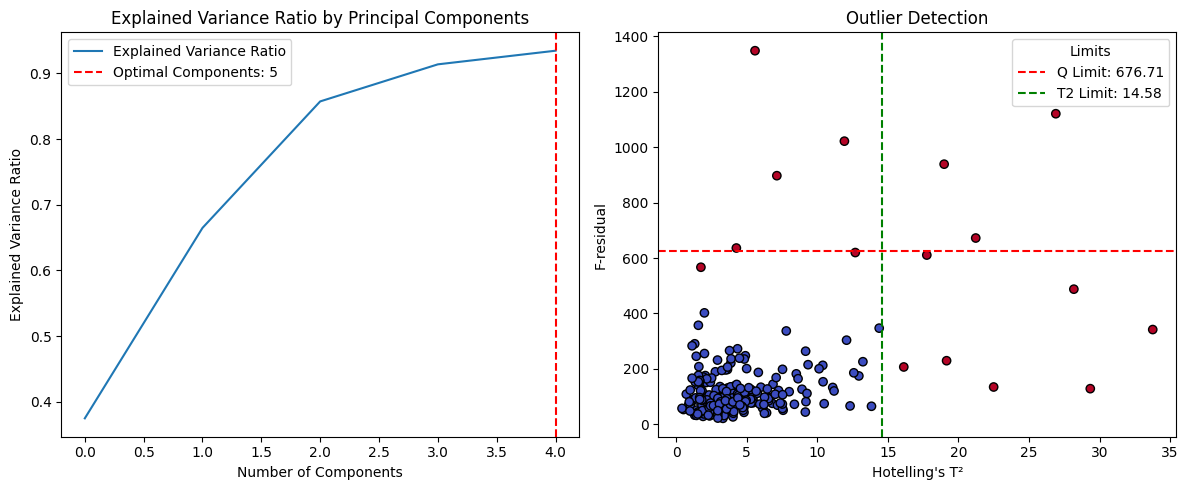

Arquivo snv_processed.xlsx processado com 5 componentes principais do PCA.


In [5]:
dataset_dir = r"C:\Users\luyza\OneDrive\Documentos\spectroscopy_machine_learning_analysis\Processed"
dataset_save = r"C:\Users\luyza\OneDrive\Documentos\spectroscopy_machine_learning_analysis\Processed\PCA"

# Iterar sobre os arquivos na pasta
for filename in os.listdir(dataset_dir):
    if filename.endswith(".xlsx"):
        dataset_path = os.path.join(dataset_dir, filename)
        df = pd.read_excel(dataset_path)

        identifiers = df.iloc[:, :6]
        data = df.iloc[:, 6:].values

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        print("Shape dos dados normalizados:", data_scaled.shape)

        n_components = jackknife_pca(data_scaled)
        pca = PCA(n_components=n_components).fit(data_scaled)
        data_pca = pca.transform(data_scaled)

        selected_indices = kennard_stone(data_pca)
        print(f"Número de amostras na calibração: {len(selected_indices)}")  # Deve ser ~70% do total

        calibration_set = df.iloc[selected_indices].sort_values(by=df.columns[0], ascending=True)
        validation_set = df.drop(df.index[selected_indices])  # Em vez de usar a máscara negada
  

        T2 = np.sum((data_pca / np.std(data_pca, axis=0)) ** 2, axis=1)
        Q = np.sum((data_scaled - pca.inverse_transform(data_pca)) ** 2, axis=1)
        T2_limit = np.mean(T2) + 2 * np.std(T2)
        Q_limit = np.mean(Q) + 2 * np.std(Q)

        outliers = (T2 > T2_limit) | (Q > Q_limit)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

        plot_data(outliers, T2, Q, T2_limit, Q_limit, cumulative_variance, n_components)
        
        save_datasets(calibration_set, validation_set, dataset_path, dataset_save)

        print(f"Arquivo {filename} processado com {n_components} componentes principais do PCA.")